# Changing vertical coordinates

In oceanography it is often required to transform the vertical coordinate system of data, e.g. from depth coordinates to temperature or density coordinates.

The general process of vertical coordinates transformation consists of two steps: Regridding and remapping.

Regridding: The process of definining the target depth coordinates (e.g. the depth defined by certain density levels or e.g. just a different depth spacing)

Remapping: Converting a data profile from the source depth profile to the target depth profile.

I am trying to design a pure python method of conservative remapping. This means that the depth integral of the data has to be conserved.

The idea is to define a weight matrix to transform the source data to the target data by multipliction with the weight matrix.

## More explanation

In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import dask.array as dsa
from dask.diagnostics import ProgressBar

In [5]:
from xarrayutils.vertical_coordinates import conservative_remap

In [6]:
def random_broadcast(ds):
#     ones = xr.DataArray(np.ones([2,6, 12]), dims=['test_a', 'test_b', 'test_c'])
    raw_noise = dsa.random.random((2000,1000,300), chunks=(500, 300, 1)) #np.random.rand(200,600,1200)
    
    noise = xr.DataArray(raw_noise, dims=['test_a', 'test_b', 'test_c'])
    new = ((noise-0.5) * 4) + ds
#     noise = xr.DataArray(np.random.rand(*ones.data.shape), coords=new.coords)#     return new
    return new

In [7]:
data = xr.DataArray(np.array([30,12.3,5]), dims=['z'])
z_bounds_source = xr.DataArray(np.array([4.5,9, 23, 45.6]), dims=['z_bounds'])
z_bounds_target = xr.DataArray(np.array([0,2,4,10,11,13.4, 23, 55.6, 80, 100]), dims=['z_bounds'])
# now for a multidimensional case
data = random_broadcast(data)
z_bounds_source = random_broadcast(z_bounds_source)
z_bounds_target = random_broadcast(z_bounds_target)

In [8]:
# determine dz
dz_source = z_bounds_source.diff('z_bounds').rename({'z_bounds':'z'})
dz_target = z_bounds_target.diff('z_bounds').rename({'z_bounds':'z_tar'})

In [13]:
xr.DataArray(np.random.rand(3,5)).chunk({})

<xarray.DataArray (dim_0: 3, dim_1: 5)>
dask.array<xarray-<this-array>, shape=(3, 5), dtype=float64, chunksize=(3, 5)>
Dimensions without coordinates: dim_0, dim_1

In [9]:
data.data.nbytes/1e9

14.4

In [3]:
# def conservative_remap(data, z_bnds_source, z_bnds_target, z_dim='z', z_dim_target='remapped',
#           z_bnd_dim='z_bounds', z_bnd_dim_target='z_bounds', mask=False):
#     """Conservatively remap `data` array from depth cells bound by `z_bnds_source` to depths bound by `z_bnds_target`
    
#     Parameters
#     ----------
#     data : xr.Dataarray
#         Input data on source coordinate system. The values need to be in units/depth, integrated quantities wont work (  I think... )
#     z_bnds_source : xr.Dataarray
#         Vertical cell bounds of the source coordinate system.
#     z_bnds_target : xr.Dataarray
#         Vertical cell bounds for the target coordinate system. !Needs to cover the full range of `z_bnds_source` to conserve depth integral.
#     z_dim : str
#         Dimension of `data` that corresponds to depth. Defaults to `'z'`
#     z_dim_target: str
#         Dimension of returned data array corresponding to depth. Defaults to `'remapped'`.
#     z_bnd_dim: str
#         As `z_dim` but for `z_bnds_source` instead of `data`. ! The dimension length needs to be +1 for the bounds
#     z_bnd_dim_target: str
#         As `z_dim` but for `z_bnds_target` instead of `data`. ! The dimension length needs to be +1 for the bounds.
#     mask: bool
#         Optional masking of completely empty cells. Will produce nans in the target cells, which do not overlap with any source cells.
#         Defaults to `False`, which produces zeros in these cells

#     Returns
#     -------
#     xr.Dataarray
#         Remapped data. Has the dimensions of data, but `z_dim` is replaced with `z_dim_target`.

#     """
#     # TODO: auto detect the dim names, when 1d arrays are provided?
    
#     # rename dimensions (this is particularly important when both have the same dim name)
#     data = data.rename({z_dim:'z'})
#     z_up = z_bnds_source[{z_bnd_dim:slice(0,-1)}].rename({z_bnd_dim:'z'})
#     z_down = z_bnds_source[{z_bnd_dim:slice(1,None)}].rename({z_bnd_dim:'z'})
    
#     z_up_tar = z_bnds_target[{z_bnd_dim_target:slice(0,-1)}].rename({z_bnd_dim_target:'z_tar'})
#     z_down_tar = z_bnds_target[{z_bnd_dim_target:slice(1,None)}].rename({z_bnd_dim_target:'z_tar'})
    
#     # Compute boundind depth of cell intersection for each combination of depth cells.
#     bound_up = xr.ufuncs.maximum(z_up,z_up_tar)
#     bound_down = xr.ufuncs.minimum(z_down,z_down_tar)
    
#     # Calculate intersection cell depth
#     # all negative values indicate that the cells do not overlap and are replaced with zero
#     delta_z = bound_down - bound_up
#     delta_z = delta_z.where(delta_z > 0, 0)
    
#     # calculate the target grid dz
#     delta_z_tar = z_down_tar - z_up_tar
    
#     #the weights for each cell are the partial dz of the source cell (delta_z) divided by the 
#     # target grid dz for each possible combination
#     w = delta_z / delta_z_tar
    
#     # The dot product of the data with the weight matrix gives the remapped values on the new grid cells.
#     new_data = xr.dot(data, w, dims='z').rename({'z_tar':z_dim_target})
    
#     # mask for values that have no input ()
#     if mask:
#         nanmask = (w == 0).all('z')
#         new_data = new_data.where(~nanmask)
        
#     return new_data

In [10]:
data.data

dask.array<add, shape=(2000, 1000, 300, 3), dtype=float64, chunksize=(500, 300, 1, 3)>

In [11]:
data_new = conservative_remap(data, z_bounds_source, z_bounds_target, mask=True)

In [12]:
with ProgressBar():
    aa = data_new.mean(['test_c', 'test_a']).load()

[##########                              ] | 25% Completed |  1min 23.8s

/Users/juliusbusecke/miniconda/envs/test_env_xarrayutils/lib/python3.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  4min 38.3s


In [25]:
raw = (data*dz_source).sum('z')
remapped = (data_new*dz_target).sum('z_tar')

In [27]:
with ProgressBar():
    xr.testing.assert_allclose(raw, remapped)

[                                        ] | 0% Completed | 16.1s


KeyboardInterrupt: 

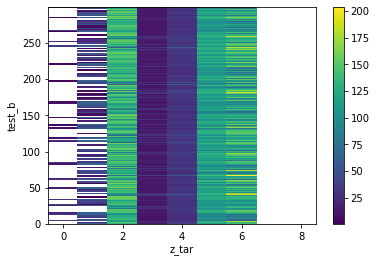

In [13]:
with ProgressBar():
(data_new*dz_target).isel(test_a=1, test_c=5).plot()